In [40]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(11, 9))
plt.rc('font', size=13)
import math


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from scipy.stats import chi2_contingency
from scipy.stats import ttest_1samp
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from env import host, user, password
from pydataset import data
import acquire
import prepare

Final Report (.ipynb) (see details above in the "Jupyter Notebook Report"

A Report that has filtered out all the extraneous elements not necessary to include in the report.

Use markdown throughout the notebook to guide the audience. Assume the reader will not read your code blocks as you think about how much markdown guidance do you need.

Then, assume another reader will read ALL of your code, so make sure it is very very clearly commented. All cells with code need comments.

Your notebook should begin with a project overview and goals and end with a conclusion that talks about your original goals and how you reached those (or didn't), the key findings, recommendations and next steps ("If I had more time, I would...")

Exploration should be refined in the report because now you know which visualizations and tests led to valuable outcomes.

Include at least 4 visualizations in the form of:

 - Question in markdown that you want to answer

 - visualization

 - statistical test (in at least 2 of your 4)

 - Provide your clear answer or takeaway in markdown and natural language to the question based on your exploration.

Provide the context of the target variable through a visualization (distribution of the values, e.g.)

Include your 3 best models in the final notebook to review. Show the steps and code you went through to fit the models, evaluate, and select.

On your best model, a chart visualizing how it performed on test would be valuable.

In [41]:
# acquire telco_df from acquire.py
telco_df = acquire.get_telco_data()

In [42]:
# steps used to prepare data from prepare.py
telco_df = prepare.prep_telco_data(telco_df)

In [43]:
train, validate, test = prepare.split_telco_data(telco_df)

In [44]:
train.shape

(3937, 24)

In [45]:
validate.shape

(1688, 24)

In [46]:
test.shape

(1407, 24)

# Project Overview

### Customer churn, also known as customer attrition, customer turnover, or customer defection, is the loss of clients or customers. In the telecommunication industry it is critical to retain customers because it is often more costly to acquire new ones. The goal of this project is to find and identify those drivers which cause customer churn at Telco.

- Will the attributes of a customers account to include contract type, paperless billing, and automatic payment affect churn? - Is not having automatic payments an indicator that a customer might possibly churn?
- Can customers who use online security, tech support, and device protection indicate whether they will churn or not?
- 

In [47]:
def percentage_stacked_plot(columns_to_plot, super_title):
    
    '''
    Prints a 100% stacked plot of the response variable for independent variable of the list columns_to_plot.
            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization
            Returns:
                    None
    '''
    
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=.95)
 

    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(telco_df[column], telco_df['churn']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0, color=['#0072BD','pink'])

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        # set title and labels
        #ax.set_title(column,
                     #fontsize=16, loc='left')

        #ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

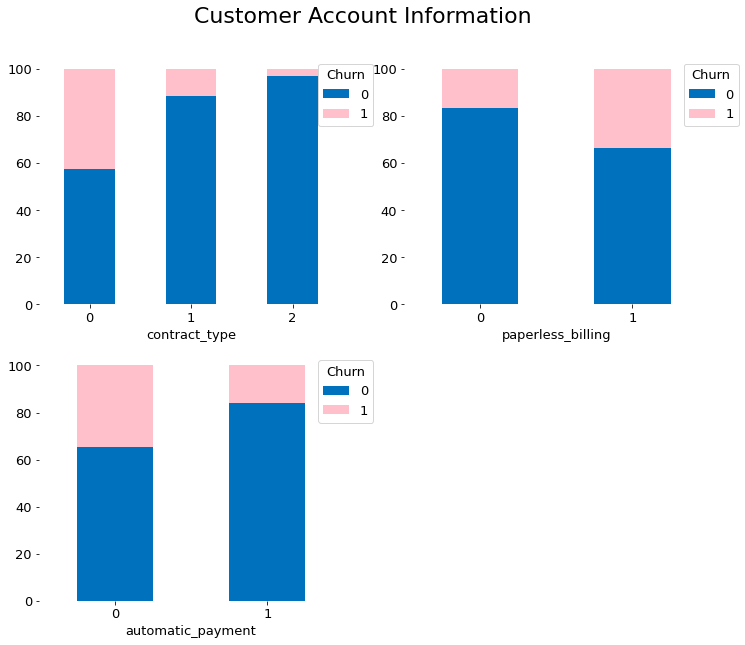

In [48]:
# customer account column names
account_columns = ['contract_type', 'paperless_billing', 'automatic_payment']

# stacked plot of customer account columns
percentage_stacked_plot(account_columns, 'Customer Account Information')

# contract type 0 is month to month, 1 is one-year, 2 is two-year
# other 0 and 1 is no and yes

### We can conclude by analyzing the above customer account attributes that:

- month-to-month contracts have higher churn rates compared to customers with yearly contracts (1 or 2 year).
- customers with paperless billing churn more than those who do not have this option.
- customers who manually pay their bill are more likely to churn.

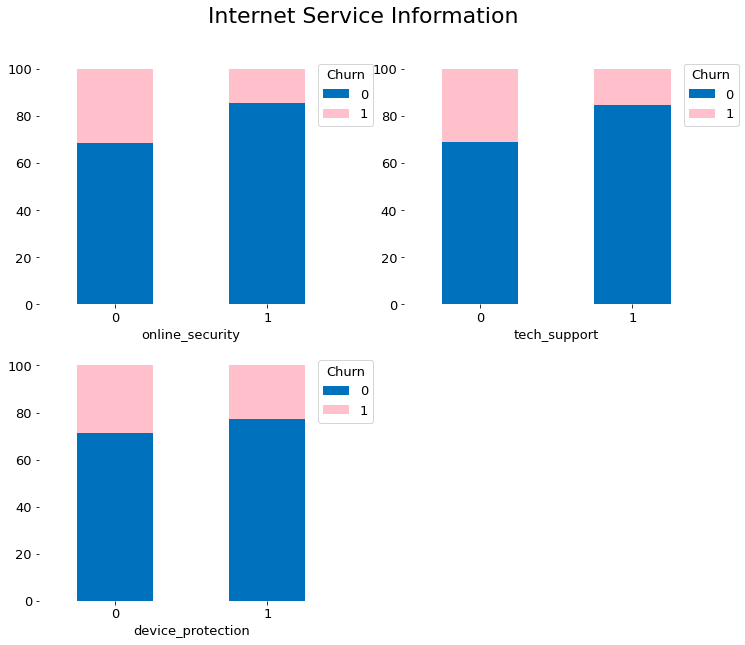

In [49]:
# services column names
services_columns = ['online_security', 'tech_support', 'device_protection']

# stacked plot of services columns

percentage_stacked_plot(services_columns, 'Internet Service Information')


### We can conlcude from the above internet service information that:

- Customers without online security churn more than those who have this service.
- Customers without tech support churn more than those who have this service.
- We cannot expect that device protection is significant in predicting churn since they are nearly the same.

<AxesSubplot:xlabel='tenure_mths', ylabel='Density'>

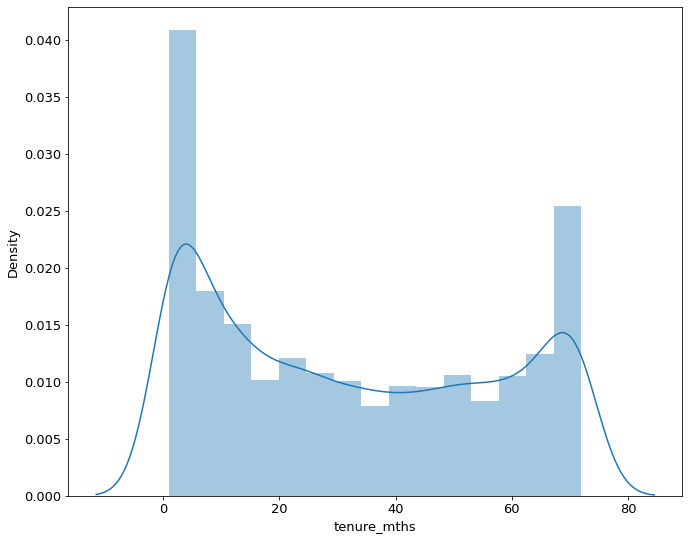

In [50]:
sns.distplot(telco_df.tenure_mths)

<AxesSubplot:xlabel='monthly_charges', ylabel='Density'>

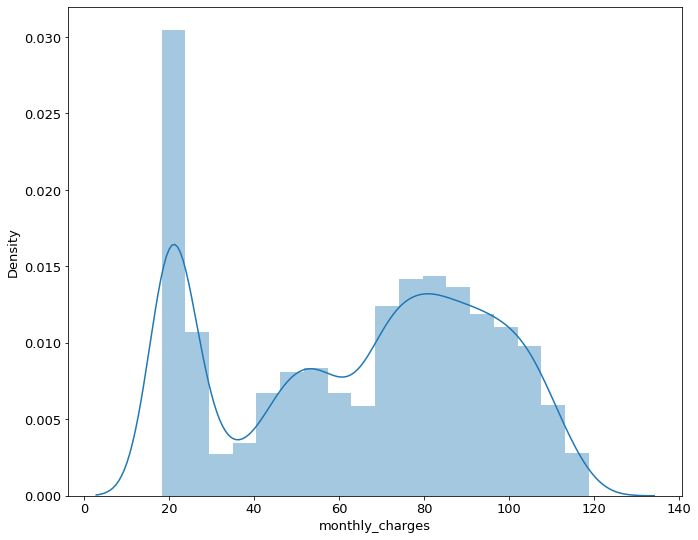

In [51]:
sns.distplot(telco_df.monthly_charges)

Text(0.5, 1.0, 'Monthly charges by churn')

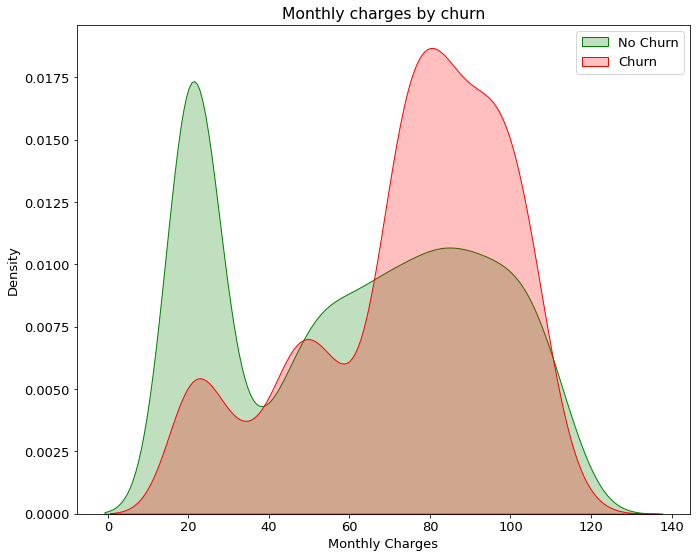

In [52]:
Mth = sns.kdeplot(train.monthly_charges[(train["churn"] == 0) ],
                color="Green", shade = True)
Mth = sns.kdeplot(train.monthly_charges[(train["churn"] == 1) ],
                ax =Mth, color="Red", shade= True)
Mth.legend(["No Churn","Churn"])
Mth.set_ylabel('Density')
Mth.set_xlabel('Monthly Charges')
Mth.set_title('Monthly charges by churn')

Text(0.5, 1.0, 'Total charges by churn')

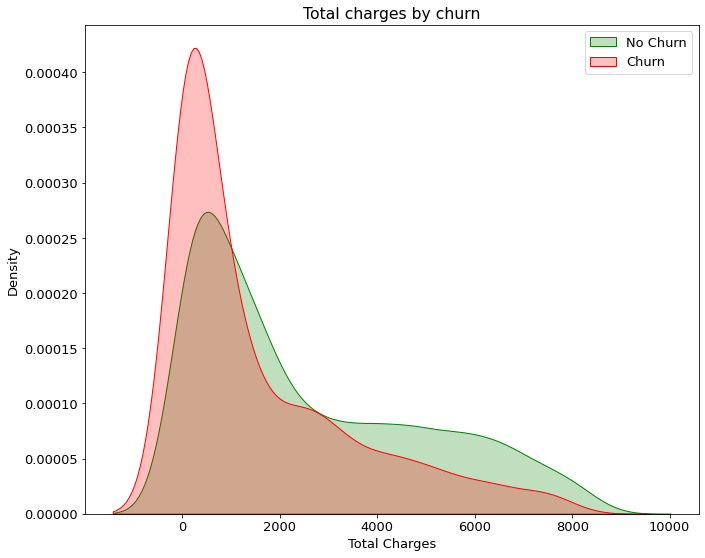

In [53]:
Tot = sns.kdeplot(train.total_charges[(train["churn"] == 0) ],
                color="Green", shade = True)
Tot = sns.kdeplot(train.total_charges[(train["churn"] == 1) ],
                ax =Tot, color="Red", shade= True)
Tot.legend(["No Churn","Churn"],loc='upper right')
Tot.set_ylabel('Density')
Tot.set_xlabel('Total Charges')
Tot.set_title('Total charges by churn')

### We can conclude from the above displot and kdeplots:
- Tenure and total charges are correlated since the longer you are a customer the more you will pay.
- Monthly charges and total charges are correlated since the more of a monthly expense would lead to a higher total expense and affect churn.